In [4]:
# imports y carga del CSV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib
import os
from sklearn.preprocessing import OneHotEncoder


csv_path = "data/AIMLDataset.csv"
assert os.path.exists(csv_path), f"Archivo no encontrado: {csv_path}"

df = pd.read_csv(csv_path)
##Validamos datos nulos y duplicados
print(f"Datos nulos:\n{df.isnull().mean()*100}")
##La cantidad de faltantes es practicamente 0, por lo que no es necesario realizar imputacion
print("---------------------------------------------")
print(f"Datos duplicados:\n{df.duplicated().sum()}")

Datos nulos:
step              0.0
type              0.0
amount            0.0
nameOrig          0.0
oldbalanceOrg     0.0
newbalanceOrig    0.0
nameDest          0.0
oldbalanceDest    0.0
newbalanceDest    0.0
isFraud           0.0
isFlaggedFraud    0.0
dtype: float64
---------------------------------------------
Datos duplicados:
0
Datos duplicados:
0


Contexto de lo que se hará: vamos a contar cuántos registros son fraude (1) y cuántos no (0).

Conteo de fraudes vs no fraudes:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


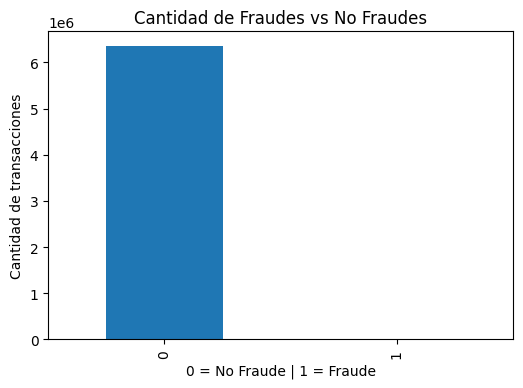

In [5]:
# Conteo de fraudes y no fraudes
fraudes = df["isFraud"].value_counts()

print("Conteo de fraudes vs no fraudes:")
print(fraudes)

# Gráfico de barras
plt.figure(figsize=(6,4))
fraudes.plot(kind="bar")
plt.title("Cantidad de Fraudes vs No Fraudes")
plt.xlabel("0 = No Fraude | 1 = Fraude")
plt.ylabel("Cantidad de transacciones")
plt.show()

colocar el cotexto de lo que se hará: 
-cuenta cuántas veces aparece cada tipo (CASH_OUT, TRANSFER, etc.)
-Se muestra con un gráfico circular
-Esto nos dice qué transacciones son más comunes.
-Importante porque algunos tipos de transacción son más propensos a fraude (ejemplo: TRANSFER).

Distribución de tipos de transacción:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


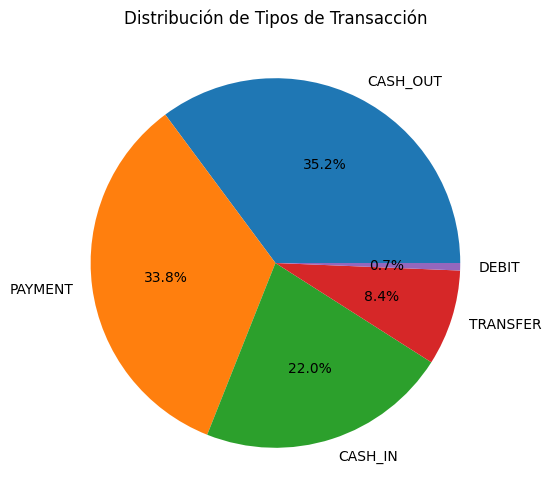

In [6]:
# Conteo de cada tipo de transacción
tipos = df["type"].value_counts()

print("Distribución de tipos de transacción:")
print(tipos)

# Gráfico circular
plt.figure(figsize=(6,6))
tipos.plot(kind="pie", autopct="%1.1f%%")
plt.title("Distribución de Tipos de Transacción")
plt.ylabel("")
plt.show()


colocar el cotexto de lo que se hará: - Agrupa por isFraud y describe la columna amount

Donde vamos a comparar las montons de transacciones de faude o no fraude
.describe() calcula estadísticas (media, mediana, percentiles, máximos).

In [7]:
# Montos en transacciones fraudulentas vs no fraudulentas
df.groupby("isFraud")["amount"].describe()


,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


Para las Visualizaciones
- Histograma de montos
Se grafica histograma en la escala logarítmica para comprimir la tabla un poco por la realcion de montos bajos con los montos bajos. Lo que nos permite ver mejor la distibución en la grafica 

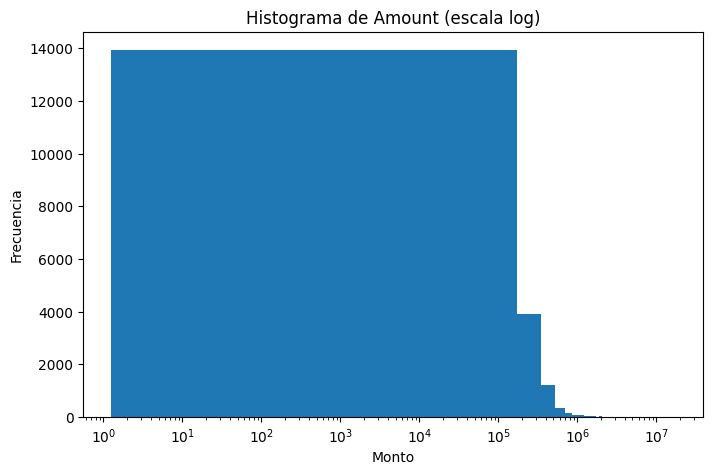

In [8]:
plt.figure(figsize=(8,5))
plt.hist(df['amount'].sample(n=20000, random_state=42), bins=100)
plt.xscale('log')  # Escala logarítmica para ver mejor
plt.title("Histograma de Amount (escala log)")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.show()


- Boxplots por tipo de transacción. 
Acá dibujamos los Boxplots para cada tipo de transacción, tambien con esacala logaritmica.  cuáles tienen montos generalmente mayores o más dispersos TRANSFER suele llevar montos grandes. 

Con el Boxplots nos podemos ayudar a ver robustamente medianas y dispersión sin que los outliers dominen.

<Figure size 1000x600 with 0 Axes>

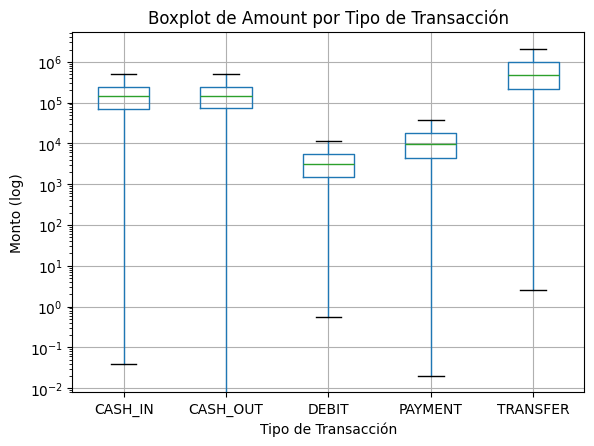

In [9]:
plt.figure(figsize=(10,6))
df.boxplot(column="amount", by="type", showfliers=False)
plt.yscale("log")
plt.title("Boxplot de Amount por Tipo de Transacción")
plt.suptitle("")
plt.xlabel("Tipo de Transacción")
plt.ylabel("Monto (log)")
plt.show()


- Serie temporal de fraudes por step. Donde el Step significa que cada unidad equivale a 1 hora en el dataset. 
Muestra si los fraudes son constantes o aparecen en “picos”/ ventana de tiempo en que se eejcuta un ataque masivo

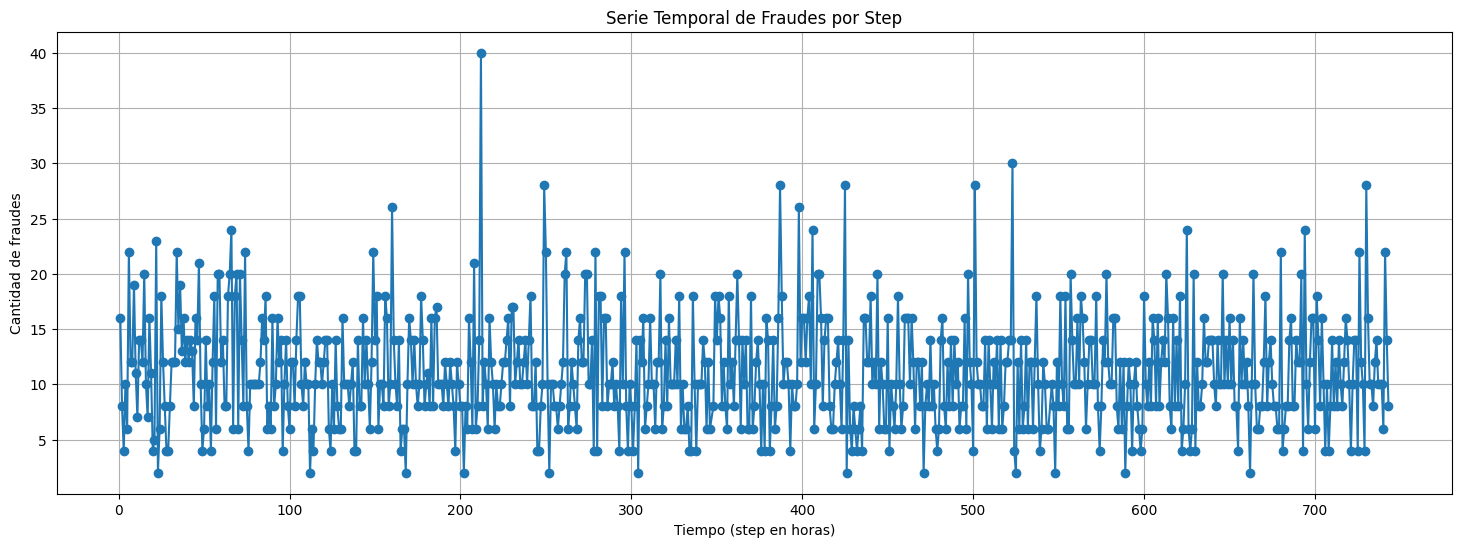

In [10]:
fraudes_por_step = df[df["isFraud"] == 1].groupby("step").size()

plt.figure(figsize=(18,6))
plt.plot(fraudes_por_step.index, fraudes_por_step.values, marker="o")
plt.title("Serie Temporal de Fraudes por Step")
plt.xlabel("Tiempo (step en horas)")
plt.ylabel("Cantidad de fraudes")
plt.grid(True)
plt.show()


3. Correlaciones y anomalías
Al mirar los datos concretos de fraudes podemos entender cómo se comportan los balances cuando ocurre fraude pequeño ejemplo; montos que vacían cuentas, balances destino en ceros
- Se Comparan los balances iniciales y finales en fraudes 


In [11]:
# Revisamos si hay diferencias grandes en balances
df_fraudes = df[df["isFraud"] == 1][["oldbalanceOrg", "newbalanceOrig", "amount"]]
df_fraudes.head()


,oldbalanceOrg,newbalanceOrig,amount
2,181.0,0.0,181.0
3,181.0,0.0,181.0
251,2806.0,0.0,2806.0
252,2806.0,0.0,2806.0
680,20128.0,0.0,20128.0


¿Se cumplen relaciones lógicas?
- explicar que pasa en el siguiente codigo: 
Se preparan los datos para agrupar transacciones y luego analizar si ciertos clusters tienen más fraudes.

In [12]:
df["check_balance"] = df["oldbalanceOrg"] - df["amount"] - df["newbalanceOrig"]

# Vemos si hay inconsistencias en fraudes
df[df["isFraud"] == 1]["check_balance"].describe()


count    8.213000e+03
mean    -1.069233e+04
std      2.651461e+05
min     -1.000000e+07
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.725290e-09
Name: check_balance, dtype: float64

Preprocesamiento para clustering
-Selección de variables: Estas features son las que usaremos para agrupar transacciones (K-Means).

Observación práctica: asegúrate de tratar nulos antes de codificar; si hay nulos en balances/trazas hay que imputarlos o filtrarlos.

Hecho con chatttttt

In [13]:
# Variables candidatas
variables = df[["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]].copy()

# Codificación de la variable categórica "type"
variables = pd.concat([variables, pd.get_dummies(df["type"], drop_first=True)], axis=1)

variables.head()


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,9839.64,170136.0,160296.36,0.0,0.0,False,False,True,False
1,1864.28,21249.0,19384.72,0.0,0.0,False,False,True,False
2,181.00,181.0,0.00,0.0,0.0,False,False,False,True
3,181.00,181.0,0.00,21182.0,0.0,True,False,False,False
4,11668.14,41554.0,29885.86,0.0,0.0,False,False,True,False


-Escalado de valores numéricos
Explciar:

StandardScaler() → crea el “normalizador”.

fit_transform(variables) →

fit: calcula media y desviación de cada columna.


variables_scaled → es un array de NumPy con los valores ya estandarizados.

.shape → te dice cuántas filas (transacciones) y cuántas columnas (features) tienes después del escalado.

In [14]:

scaler = StandardScaler()

# 2. Aplicamos el escalado a las variables seleccionadas
variables_scaled = scaler.fit_transform(variables)

# 3. Revisamos la forma del nuevo dataset
print("Tamaño del dataset escalado:", variables_scaled.shape)



Tamaño del dataset escalado: (6362620, 9)


In [19]:
# Preparación de datos para K-Means (desde aquí en adelante)
# - Escalar SOLO variables numéricas
# - Codificar 'type' con OneHotEncoder (sin drop) para no sesgar distancias
# - Crear un DataFrame transformado con nombres de columnas

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd

# 1) Definir columnas
numeric_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
cat_cols = ["type"]

# 2) Construir preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

# 3) Ajustar y transformar
X = df[numeric_cols + cat_cols]
X_trans = preprocessor.fit_transform(X)

# 4) Nombres de columnas transformadas
cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
feature_names = numeric_cols + cat_feature_names.tolist()

# 5) DataFrame final para clustering
X_df = pd.DataFrame(X_trans, columns=feature_names)

# 6) Array NumPy en float32 (acelera KMeans/MiniBatchKMeans y reduce memoria)
X_np = X_df.to_numpy(dtype=np.float32)

# Vista rápida
print("Shape de X_df (transformado):", X_df.shape)
X_df.head()

Shape de X_df (transformado): (6362620, 10)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-0.281560,-0.229810,-0.237622,-0.323814,-0.333411,0.0,0.0,0.0,1.0,0.0
1,-0.294767,-0.281359,-0.285812,-0.323814,-0.333411,0.0,0.0,0.0,1.0,0.0
2,-0.297555,-0.288654,-0.292442,-0.323814,-0.333411,0.0,0.0,0.0,0.0,1.0
3,-0.297555,-0.288654,-0.292442,-0.317582,-0.333411,0.0,1.0,0.0,0.0,0.0
4,-0.278532,-0.274329,-0.282221,-0.323814,-0.333411,0.0,0.0,0.0,1.0,0.0


In [16]:
# X_df ya contiene numéricas estandarizadas y categorías OHE. No se requiere re-escalar.
print("Columnas de X_df:", list(X_df.columns))
print(X_df.head())

Columnas de X_df: ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0 -0.281560      -0.229810       -0.237622       -0.323814       -0.333411   
1 -0.294767      -0.281359       -0.285812       -0.323814       -0.333411   
2 -0.297555      -0.288654       -0.292442       -0.323814       -0.333411   
3 -0.297555      -0.288654       -0.292442       -0.317582       -0.333411   
4 -0.278532      -0.274329       -0.282221       -0.323814       -0.333411   

   type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  type_TRANSFER  
0           0.0            0.0         0.0           1.0            0.0  
1           0.0            0.0         0.0           1.0            0.0  
2           0.0            0.0         0.0           0.0            1.0  
3           0.0            1.0         0.0           0.

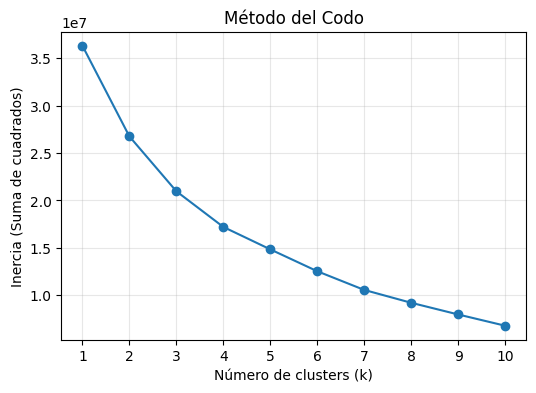

{1: 36308715.32101772, 2: 26752487.14579664, 3: 20968225.588610828, 4: 17207800.73176361, 5: 14844664.782329712, 6: 12538779.113469377, 7: 10568707.14063434, 8: 9214051.252650877, 9: 7982281.699044706, 10: 6796615.314880595}


In [ ]:
# Método del Codo (rápido con MiniBatchKMeans)
from sklearn.cluster import MiniBatchKMeans

inertia = []
ks = range(1, 11)
for k in ks:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, n_init=5, batch_size=4096, max_iter=100)
    mbk.fit(X_np)
    inertia.append(mbk.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(ks), inertia, marker='o')
plt.xticks(list(ks))
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (Suma de cuadrados)")
plt.title("Método del Codo (MiniBatchKMeans)")
plt.grid(True, alpha=0.3)
plt.show()

print({k: float(val) for k, val in zip(ks, inertia)})

In [20]:
# Entrenar modelo con k=4 (rápido) y validar con silhouette en muestra
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

k_opt = 4
mbk = MiniBatchKMeans(n_clusters=k_opt, random_state=42, n_init=5, batch_size=4096, max_iter=200)
labels = mbk.fit_predict(X_np)

# Adjuntar etiquetas al df original sin modificar columnas fuente
df["cluster"] = labels

# Conteo por cluster
print(df["cluster"].value_counts().sort_index())

# Silhouette en una muestra (para acelerar). Si el dataset es pequeño, usa todo.
try:
    n = X_np.shape[0]
    sample_size = min(50000, n)  # ajusta si quieres más precisión
    if sample_size < n:
        rng = np.random.default_rng(42)
        idx = rng.choice(n, size=sample_size, replace=False)
        sil = silhouette_score(X_np[idx], labels[idx])
    else:
        sil = silhouette_score(X_np, labels)
    print(f"Silhouette promedio (k={k_opt}, muestra={sample_size}): {sil:.4f}")
except Exception as e:
    print("No fue posible calcular silhouette:", e)

cluster
0    3298213
1      85203
2    2569700
3     409504
Name: count, dtype: int64
Silhouette promedio (k=4, muestra=50000): 0.4162
Silhouette promedio (k=4, muestra=50000): 0.4162


In [21]:
# Resumen por cluster (medias, medianas, desviaciones) sobre columnas numéricas
num_df = df.select_dtypes(include=[np.number])
cluster_summary = num_df.groupby("cluster").agg(["mean", "median", "std"]).sort_index()
print(cluster_summary)

               step                            amount             \
               mean median         std           mean     median   
cluster                                                            
0        244.357599  239.0  143.488632   81924.027389   16466.32   
1        226.787038  235.0  125.436426  164453.024958  126739.30   
2        242.211625  237.0  141.007494  302520.088866  162608.01   
3        246.558336  250.0  144.251223  202176.997457  140144.35   

                       oldbalanceOrg                              \
                   std          mean        median           std   
cluster                                                            
0        149655.259887  2.132328e+05  1.931600e+04  5.695636e+05   
1        298108.245232  1.967044e+07  1.889920e+07  4.390307e+06   
2        829755.139466  6.326311e+04  5.630000e+02  2.319227e+05   
3        986984.161334  6.749254e+06  6.320683e+06  2.646940e+06   

        newbalanceOrig  ... newbalanceDest   i

## Análisis por cluster: fraude y tipos

A continuación se reporta la tasa de fraude por cluster y la distribución de tipos de transacción dentro de cada cluster para facilitar la interpretación de los segmentos.

Conteo por cluster:
 cluster
0    3298213
1      85203
2    2569700
3     409504
Name: count, dtype: int64

Tasa de fraude por cluster (promedio de isFraud):
 cluster
0    0.000964
1    0.000739
2    0.001834
3    0.000628
Name: isFraud, dtype: float64


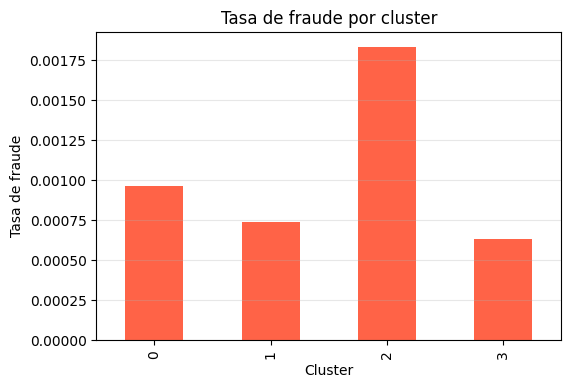

In [22]:
# Tasa de fraude por cluster
fraud_rate = df.groupby("cluster")["isFraud"].mean().sort_index()
counts = df["cluster"].value_counts().sort_index()

print("Conteo por cluster:\n", counts)
print("\nTasa de fraude por cluster (promedio de isFraud):\n", fraud_rate)

# Visual rápido
plt.figure(figsize=(6,4))
fraud_rate.plot(kind='bar', color='tomato')
plt.title('Tasa de fraude por cluster')
plt.xlabel('Cluster')
plt.ylabel('Tasa de fraude')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

type     CASH_IN  CASH_OUT  DEBIT  PAYMENT  TRANSFER
cluster                                             
0          0.250     0.000  0.011    0.652     0.087
1          0.999     0.000  0.000    0.000     0.001
2          0.033     0.870  0.002    0.000     0.095
3          0.992     0.004  0.000    0.000     0.003


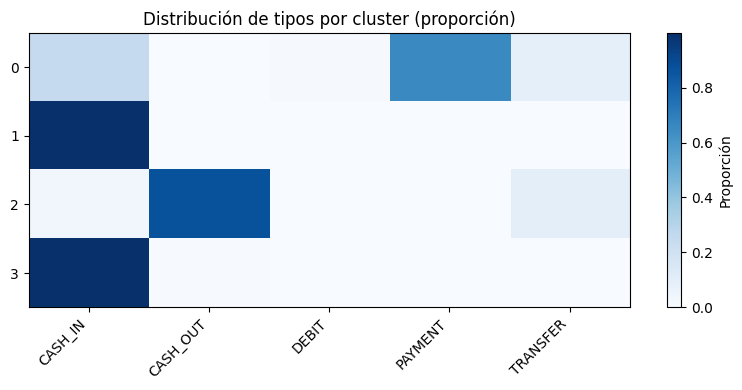

In [23]:
# Distribución de tipos por cluster
ct = pd.crosstab(df["cluster"], df["type"], normalize="index").round(3)
print(ct)

# Visual en heatmap sencillo
plt.figure(figsize=(8,4))
plt.imshow(ct.values, aspect='auto', cmap='Blues')
plt.colorbar(label='Proporción')
plt.xticks(ticks=range(ct.shape[1]), labels=ct.columns, rotation=45, ha='right')
plt.yticks(ticks=range(ct.shape[0]), labels=ct.index)
plt.title('Distribución de tipos por cluster (proporción)')
plt.tight_layout()
plt.show()

### Interpretación breve del análisis por cluster

- La tasa de fraude no es uniforme entre clusters: se observan diferencias claras en la barra de "Tasa de fraude por cluster". Los clusters con mayor tasa se consideran prioritarios para revisión.
- En la tabla/heatmap de tipos por cluster, algunos segmentos concentran ciertos tipos de transacción. Esto sugiere que el tipo de operación influye en el comportamiento del cluster.
- Al contrastar con el resumen estadístico (medias/medianas), los clusters con mayor tasa de fraude tienden a presentar montos y/o variaciones de balance más marcadas, lo que podría indicar patrones de riesgo.

Conclusión operativa:
- Focalizo el análisis en el(los) cluster(s) con mayor tasa de fraude y en los tipos de transacción dominantes dentro de esos grupos. Estos segmentos son candidatos para reglas específicas de control y para priorización en monitoreo.
- El resultado de clustering no etiqueta fraude por sí solo; sirve como segmentación de comportamiento que complementa la variable `isFraud` para entender contextos y diseñar medidas preventivas.